## Problem definition:
- different segments of new and existing customers to target for selling credit card
- credit card customers perceived the support services of the bank poorly

### Questions to be answered:
- What are the recommendation of upgrades for the service delivery model?
- Which channel to focus on ensuring customer's queries are resolved faster?
- How to identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank?
- How many segments of credit card customers are there?
- How are these segments different from each other?
- What are the recommendations to the bank on how to better market to and service these customers?

Importing Required Libraries:

In [1]:
# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist

# to perform KMeans & hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to compute silhouette score
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform PCA
from sklearn.decomposition import PCA

<IPython.core.display.Javascript object>

In [2]:
# loading the dataset
data = pd.read_excel("Credit Card Customer Data.xlsx")
data.shape

(660, 7)

<IPython.core.display.Javascript object>

- The dataset has 660 rows and 7 columns

# 0) Data background and contents

In [3]:
# viewing a random sample of the dataset
data.sample(n=10, random_state=1)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3
341,342,70779,18000,4,3,2,0
647,648,79953,183000,9,0,9,2
218,219,28208,19000,3,1,5,7
120,121,16577,10000,4,2,4,6
134,135,31256,13000,4,1,5,7


<IPython.core.display.Javascript object>

In [4]:
# copying the data to another variable to avoid any changes to original data
df = data.copy()

<IPython.core.display.Javascript object>

In [5]:
# let's look at the structure of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


<IPython.core.display.Javascript object>

In [6]:
# dropping the Sl_No column as it does not provide any information
df.drop("Sl_No", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [7]:
# let's check for duplicate observations
df.duplicated().sum()

0

<IPython.core.display.Javascript object>

Note that the 'Customer Key' is a unique ID given to each customer in the database, and can be ignored during the analysis.

In [8]:
# create a list of numeric columns to be analysed
num_col = df.columns.tolist()
num_col.remove("Customer Key")
num_col

['Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

<IPython.core.display.Javascript object>

In [9]:
df[num_col].describe()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000
mean,34574.242424,4.706061,2.403030,2.606061,3.583333
std,37625.487804,2.167835,1.631813,2.935724,2.865317
min,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,48000.000000,6.000000,4.000000,4.000000,5.000000
max,200000.000000,10.000000,5.000000,15.000000,10.000000


<IPython.core.display.Javascript object>

- There are extreme outliers in Avg_Credit_Limit column because mean and median values of this variable are far apart, which are 34,574 and 18,000 respectively.
- At least 50% of customers have about 5 to 10 credit cards.
- Majority of customers contacted the bank for queries 1 to 4 times through visiting the bank or online; and majority of custommers contacted the bank through call centre 1 to 5 times.

In [10]:
# checking for missing values
df.isna().sum()

Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

<IPython.core.display.Javascript object>

- There are no missing values in our data

# 1) EDA

## 1.1) Univariate Analysis

In [11]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

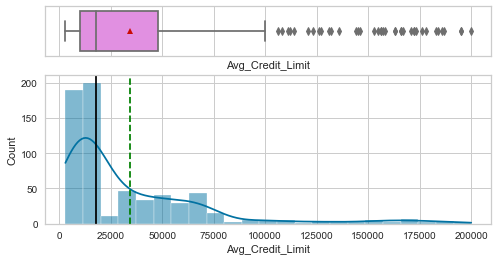

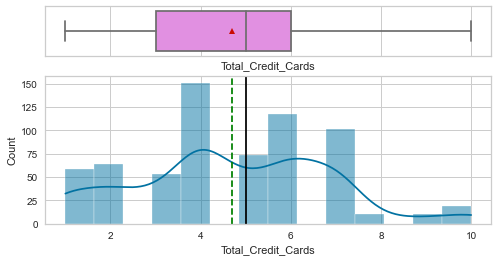

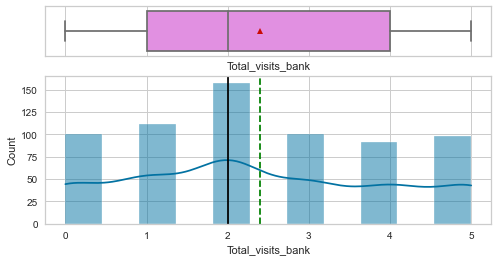

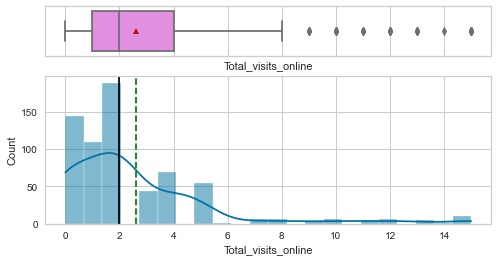

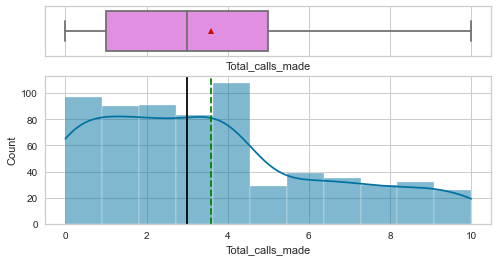

<IPython.core.display.Javascript object>

In [12]:
for item in num_col:
    histogram_boxplot(df, item, kde=True, figsize=(8, 4))

- Avg_Credit_Limit and Total_visits_online have right-skewed distributions with upper outliers. This represents the real market trend as some people do have extremely high credit limits and some people might also contact the banks 10 to 15 times to resolve issues.
- Majority of customers have 3 to 6 credit cards. The mean value of its distribution is approx 4.7 but at least 50% of customers hold 5 to 10 credit cards.
- The maximum number of visits to the bank by customers is 5.
- The distribution of Total_calls_made is somewhat slightly right-skewed. Majority of customers contacted call centre less than 5 times for queries.

In [13]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

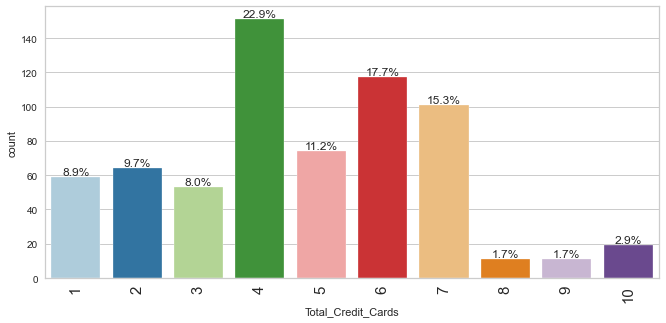

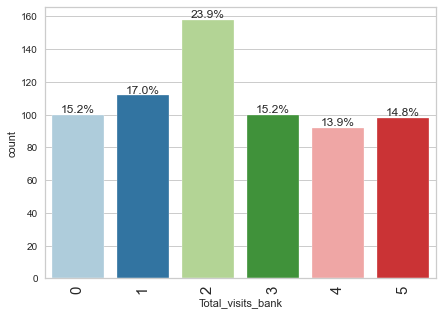

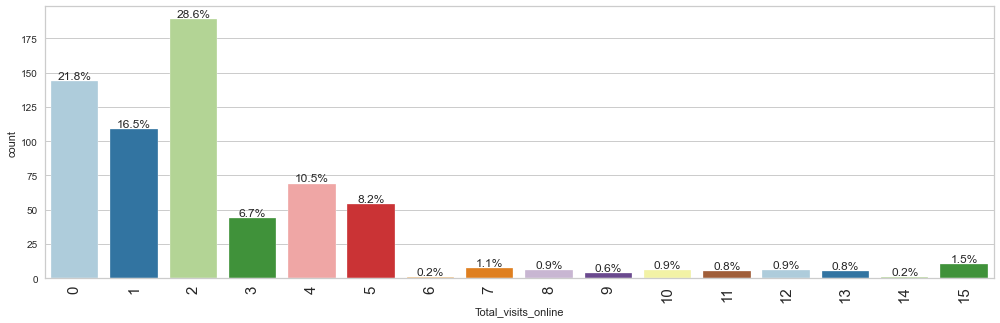

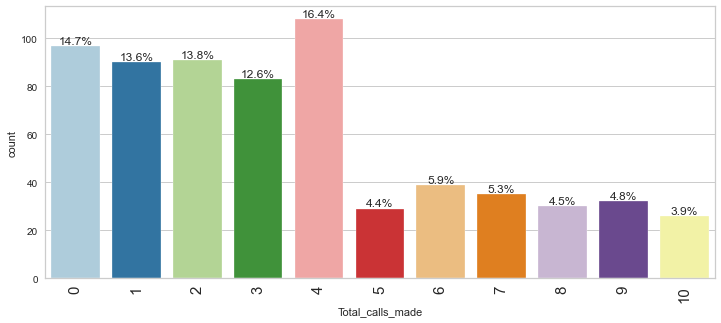

<IPython.core.display.Javascript object>

In [14]:
for item in num_col[1:]:
    labeled_barplot(df, item, perc=True)

-  Most customers hold 4 credit cards (22.9%), followed by 6 credit cards (17.7%), and then 7 credit cards (15.3%).
- 23.9% of customers visited the bank 2 times for queries.
- 92.3% of customers contacted the bank online not more than 5 times for queries.
- 71.1% of customers contacted the bank via call centre less than 5 times for queries.

#### Let's take a closer look with cumulative distribution functions:

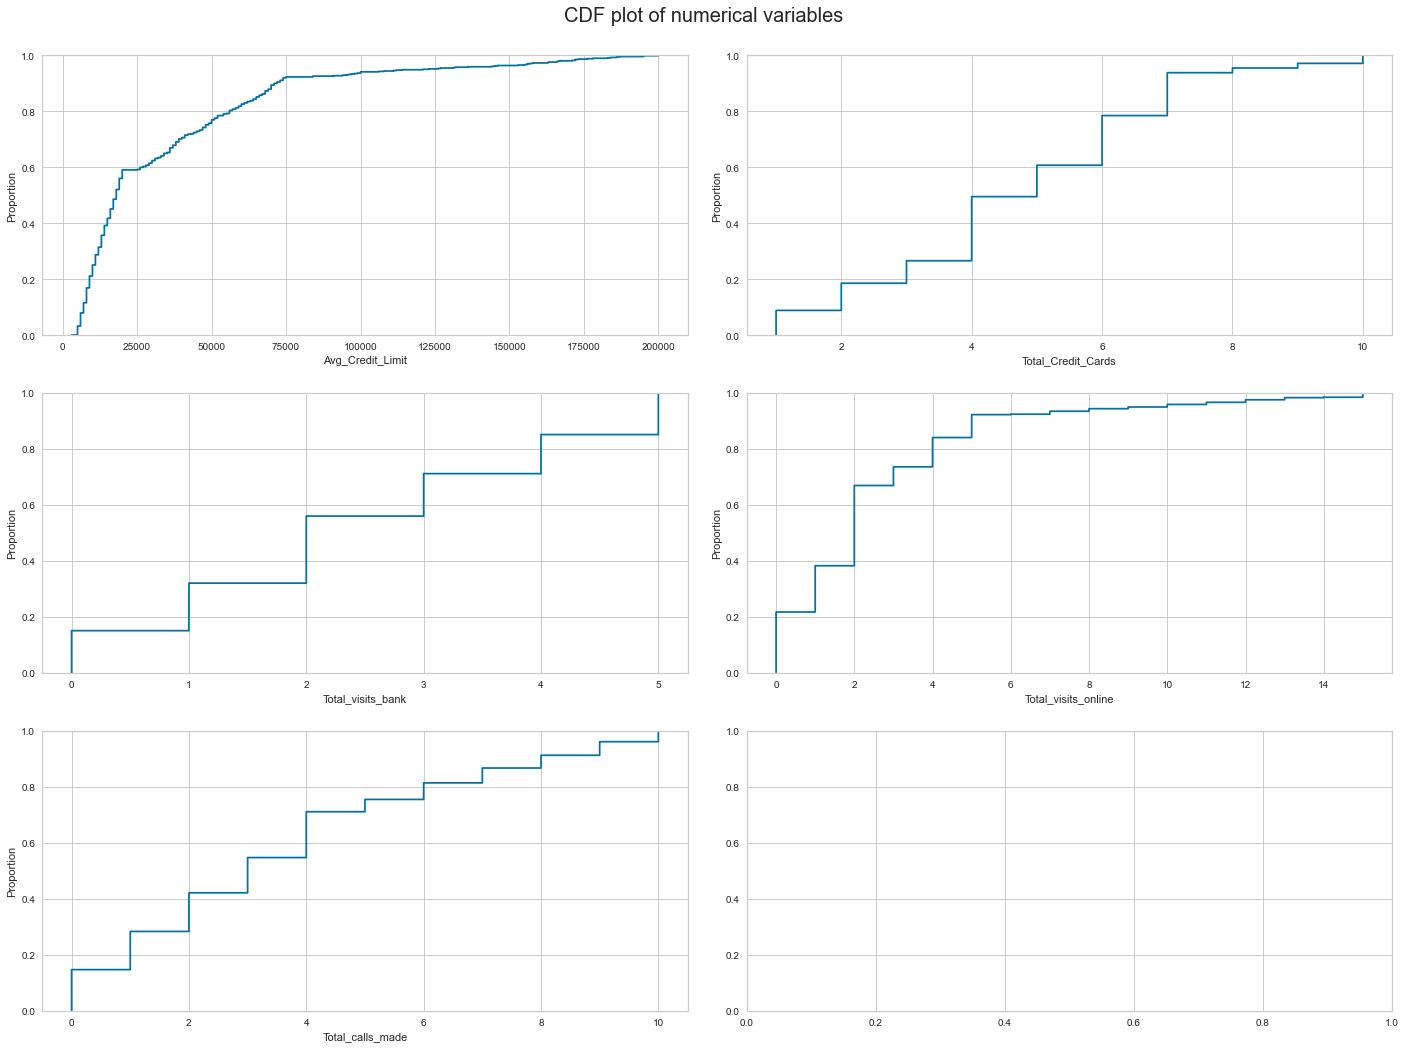

<IPython.core.display.Javascript object>

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle("CDF plot of numerical variables", fontsize=20)
counter = 0
for ii in range(3):
    sns.ecdfplot(ax=axes[ii][0], x=df[num_col[counter]])
    counter = counter + 1
    if counter != 5:
        sns.ecdfplot(ax=axes[ii][1], x=df[num_col[counter]])
        counter = counter + 1
    else:
        pass

fig.tight_layout(pad=2.0)

In [16]:
num_col

['Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

<IPython.core.display.Javascript object>

- The Avg_Credit_Limit of at least 90% of customers is less than 75,000.
- Less than 20% of customers hold more than 7 credit cards.
- More than 80% of customers visited the bank less than 5 times for queries.
- As seen earlier there are more than 90% of customers contacted the bank online less than 6 times for queries.
- At least 90% of customers contacted the bank via call centre less than 9 times for queries.

## 1.2) Bivariate Analysis

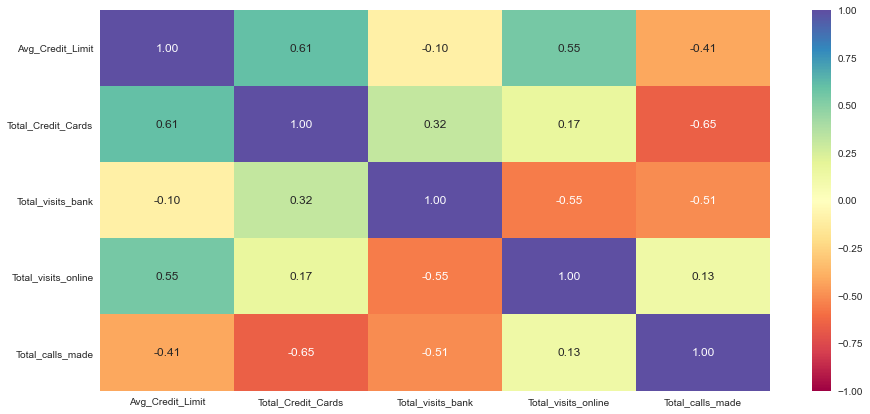

<IPython.core.display.Javascript object>

In [17]:
# checking for correlations
plt.figure(figsize=(15, 7))
sns.heatmap(df[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

- The Total_Credit_Cards and the Avg_Credit_Limit are somewhat positively correlated, which is reasonable because the more credit cards a customer has the more likely his average credit limit tends to be higher.
- Total_calls_made is somewhat negatively correlated with Total_Credit_Cards, likely because a customer with more credit cards tends to be more familiar with the usage of credit cards so the needs to contact the banks via call centre is lesser. However, Total_Credit_Cards doesn't have any apparent correlation relationship with Total_visits_bank and Total_visits_online. We need to further analyse it to understand more.
- Total_visits_bank is somewhat negatively correlated with Total_visits_online and Total_calls_made indicates that the customers have gotten gotten their queries settled via online or call centre so they don't have to visit to the bank.
- One interesting observation is that, Avg_Credit_Limit is somewhat positively correlated with Total_visits_online but is fairly negatively correlated with Total_calls_made. It seems that customers with higher average credit limit tend to contact the bank via online and less preferred to contact via call centre.

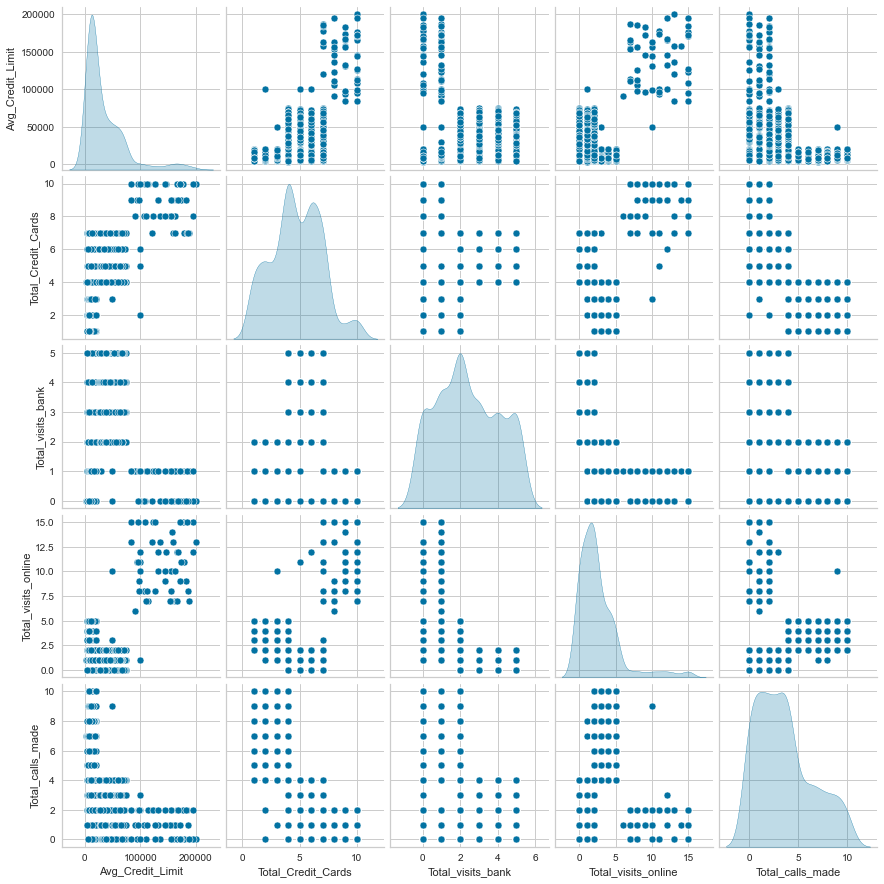

<IPython.core.display.Javascript object>

In [18]:
sns.pairplot(data=df[num_col], diag_kind="kde")
plt.show()

- Customers who visited banks 3 to 5 times have less than 90K average credit limit, while those whose average credit limit above 90K visited to the bank 2 times or less.
- Customers who contacted the bank via call centre 5 or more times have less than 26K average credit limit (with an outlier whose average credit limit was 50K), and they hold only 4 or less credit cards.
- In contrast, customers whose average credit limit above 90K contacted the bank 6 to 15 times via online, as compared with less than 6 times for those with average credit limit below 90K.
- Interestingly, customers who hold 1-4 credit cards tend to contact the banks more often via call centre for queries; while those who hold 4-7 credit cards contact the bank more often by visiting to the bank; and those who hold 7-10 credit cards contacteed the bank more often via online.

# 2) Data Preprocessing

**We will perform our analysis with and without outliers and see if there is any difference in the results. Hence, let's create two sub-datasets, namely:** <br>
&emsp;&emsp; - subset1 for the sub-dataset with outliers <br>
&emsp;&emsp; - subset2 for the sub-dataset without outliers

In [19]:
subset1 = df[num_col].copy()
subset2 = df[num_col].copy()

<IPython.core.display.Javascript object>

In [20]:
# Scaling the data set before clustering
scaler1 = StandardScaler()
subset_scaled1 = scaler1.fit_transform(subset1)

<IPython.core.display.Javascript object>

In [21]:
# Creating a dataframe from the scaled data
subset_scaled_df1 = pd.DataFrame(subset_scaled1, columns=subset1.columns)

<IPython.core.display.Javascript object>

Treating Outliers:

In [22]:
# Capping values for Avg_Credit_Limit and Total_visits_online at upper extreme of upper whisker
subset2["Avg_Credit_Limit"].clip(upper=100000, inplace=True)
subset2["Total_visits_online"].clip(upper=8, inplace=True)

<IPython.core.display.Javascript object>

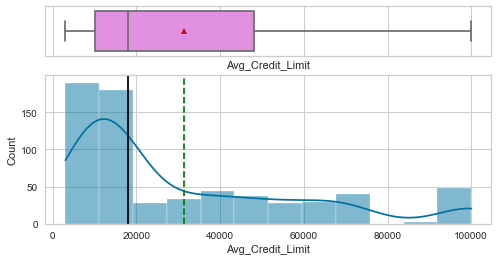

<IPython.core.display.Javascript object>

In [23]:
histogram_boxplot(subset2, "Avg_Credit_Limit", kde=True, figsize=(8, 4))

In [24]:
# Scaling the data set before clustering
scaler2 = StandardScaler()
subset_scaled2 = scaler2.fit_transform(subset2)

# Creating a dataframe from the scaled data
subset_scaled_df2 = pd.DataFrame(subset_scaled2, columns=subset2.columns)

<IPython.core.display.Javascript object>

# 3) Clustering of dataset with <ins>outliers</ins>
## 3.1) K-means Clustering

In [25]:
def elbow_method(subset_scaled_df):
    """
    To perform Elbow Method

    subset_scaled_df: dataframe
    """

    clusters = range(1, 9)
    meanDistortions = []

    for k in clusters:
        model = KMeans(n_clusters=k)
        model.fit(subset_scaled_df)
        prediction = model.predict(subset_scaled_df)
        distortion = (
            sum(
                np.min(
                    cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1
                )
            )
            / subset_scaled_df.shape[0]
        )

        meanDistortions.append(distortion)

        print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

    plt.plot(clusters, meanDistortions, "bx-")
    plt.xlabel("k")
    plt.ylabel("Average Distortion")
    plt.title("Selecting k with the Elbow Method", fontsize=20)

<IPython.core.display.Javascript object>

In [26]:
def sil_score(subset_scaled_df):
    """
    To check silhouette scores

    subset_scaled_df: dataframe
    """

    sil_score = []
    cluster_list = list(range(2, 10))
    for n_clusters in cluster_list:
        clusterer = KMeans(n_clusters=n_clusters)
        preds = clusterer.fit_predict((subset_scaled_df))
        # centers = clusterer.cluster_centers_
        score = silhouette_score(subset_scaled_df, preds)
        sil_score.append(score)
        print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

    plt.plot(cluster_list, sil_score)

<IPython.core.display.Javascript object>

Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9904384353071455
Number of Clusters: 6 	Average Distortion: 0.9430843103448057
Number of Clusters: 7 	Average Distortion: 0.9093703386475
Number of Clusters: 8 	Average Distortion: 0.8902871867973862


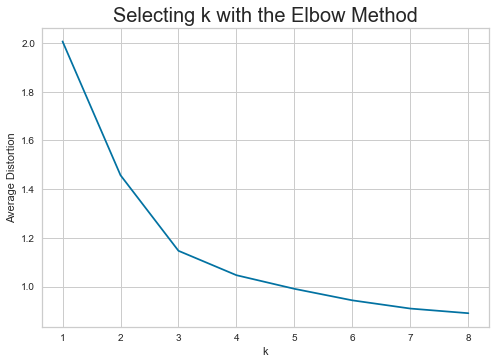

<IPython.core.display.Javascript object>

In [27]:
elbow_method(subset_scaled_df1)

- **Appropriate value for k seems to be 3 or 4.**|

For n_clusters = 2, silhouette score is 0.41842496663215445)
For n_clusters = 3, silhouette score is 0.5157182558881063)
For n_clusters = 4, silhouette score is 0.3556670619372605)
For n_clusters = 5, silhouette score is 0.2717470361089752)
For n_clusters = 6, silhouette score is 0.25545029453623114)
For n_clusters = 7, silhouette score is 0.2479547871676149)
For n_clusters = 8, silhouette score is 0.24194032276202432)
For n_clusters = 9, silhouette score is 0.21064303771801074)


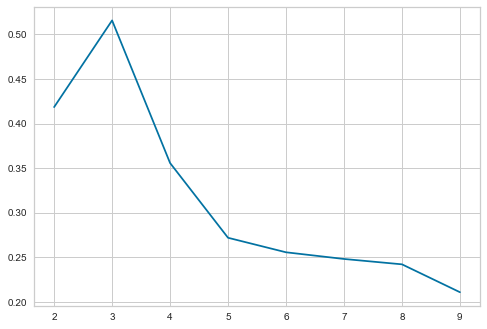

<IPython.core.display.Javascript object>

In [28]:
# Let's check the silhouette scores
sil_score(subset_scaled_df1)

- **Silhouette score for 3 is much higher than that for 4. So, we will choose 3 as value of k.**

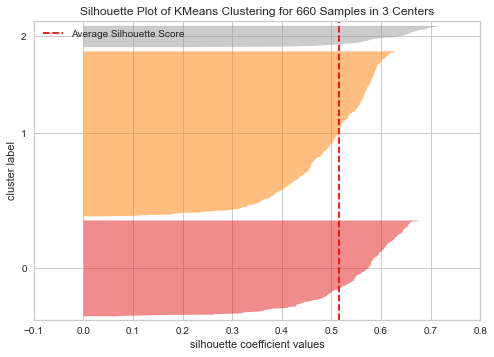

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [29]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_scaled_df1)
visualizer.show()

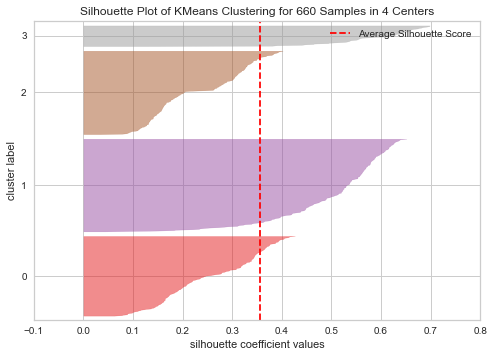

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [30]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_df1)
visualizer.show()

In [31]:
# let's take 3 as number of clusters
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(subset_scaled_df1)

KMeans(n_clusters=3, random_state=0)

<IPython.core.display.Javascript object>

### 3.1.1) Cluster Profiling

In [32]:
# copying df and scaled df to another variable to retain original df for Hierarchical clustering
df1_Kmean = df[num_col].copy()
subset_scaled_df1_Kmean = subset_scaled_df1.copy()

df1_Kmean["K_means_segments_outliers"] = kmeans.labels_
subset_scaled_df1_Kmean["K_means_segments_outliers"] = kmeans.labels_

cluster_profile_df1_Kmean = df1_Kmean.groupby("K_means_segments_outliers").mean()

cluster_profile_df1_Kmean["count_in_each_segments_outliers"] = (
    df1_Kmean.groupby("K_means_segments_outliers")["Avg_Credit_Limit"].count().values
)

# let's display cluster profiles
cluster_profile_df1_Kmean.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments_outliers
K_means_segments_outliers,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

In [33]:
def boxplot_cluster(data, segments):
    """
    Boxplots of different clusters

    Data: dataframe
    Segments: dataframe column that list the clusters
    """

    fig, axes = plt.subplots(1, 5, figsize=(16, 6))
    fig.suptitle("Boxplot of numerical variables for each cluster", fontsize=20)
    counter = 0
    for ii in range(5):
        sns.boxplot(
            ax=axes[ii],
            y=data[num_col[counter]],
            x=data[segments],
        )
        counter = counter + 1

    fig.tight_layout(pad=2.0)

<IPython.core.display.Javascript object>

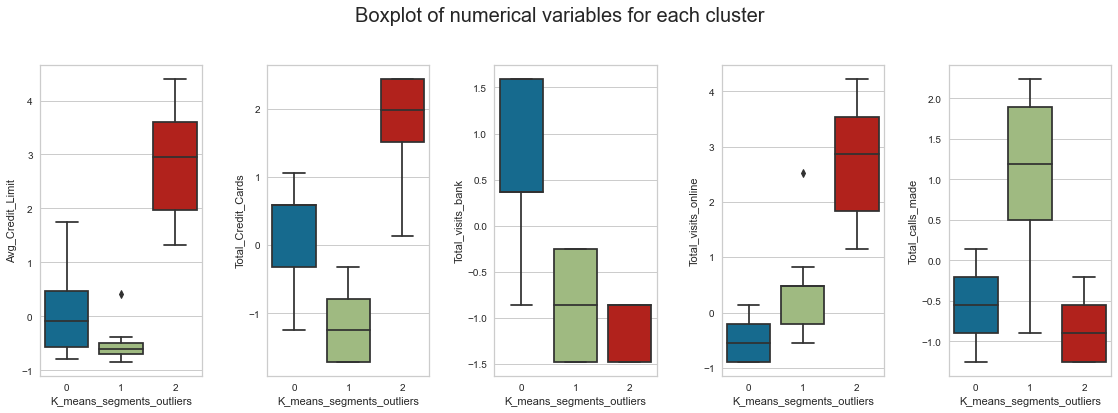

<IPython.core.display.Javascript object>

In [34]:
boxplot_cluster(subset_scaled_df1_Kmean, "K_means_segments_outliers")

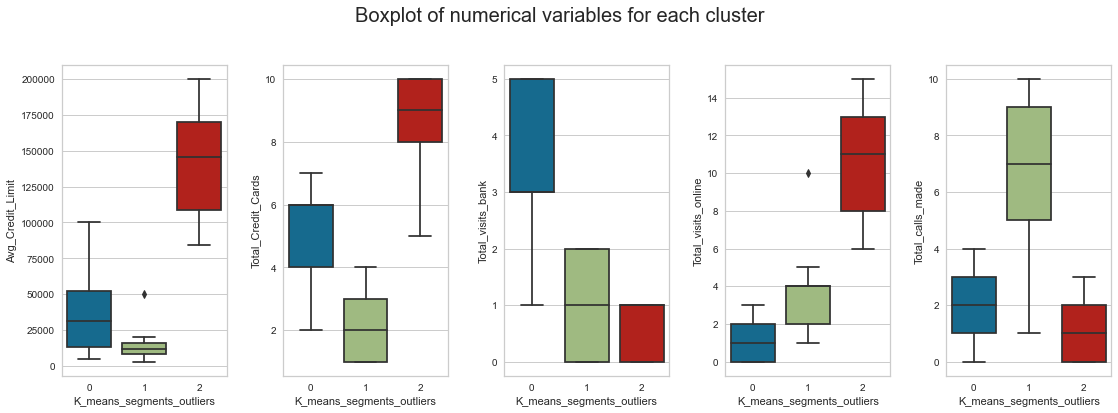

<IPython.core.display.Javascript object>

In [35]:
boxplot_cluster(df1_Kmean, "K_means_segments_outliers")

### 3.1.2) Insights from K-means Clustering for dataset with outliers:

- **Clusters 0**:
    - Low to medium average credit limit.
    - hold 2 to 7 credit cards (50% of customers hold 4 to 6 credit catds).
    - Most often contacted the bank for queries <ins>by visiting the bank</ins>.
    - Least likely to contact the bank via online.
    
- **Clusters 1**:
    - Very low average credit limit.
    - Hold 1 to 4 credit cards.
    - Most often contacted the bank for queries <ins>through a call centre</ins>.
    - Least likely to contact the bank by visiting the bank.

- **Clusters 2**:
    - High average credit limit.
    - Hold 5 to 10 credit cards (majority of them hold 8 to 10 credit cards).
    - Most often contacted the bank for queries <ins>via online</ins>.

## 3.2) Hierarchical Clustering

In [36]:
def coph_corr(subset_scaled_df):
    """
    Cophenetic correlation for different distance metrics and linkage methods

    subset_scaled_df: dataframe
    """
    # list of distance metrics
    distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

    # list of linkage methods
    linkage_methods = ["single", "complete", "average", "weighted"]

    high_cophenet_corr = 0
    high_dm_lm = [0, 0]

    for dm in distance_metrics:
        for lm in linkage_methods:
            Z = linkage(subset_scaled_df, metric=dm, method=lm)
            c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
            print(
                "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                    dm.capitalize(), lm, c
                )
            )
            if high_cophenet_corr < c:
                high_cophenet_corr = c
                high_dm_lm[0] = dm
                high_dm_lm[1] = lm

    # printing the combination of distance metric and linkage method with the highest cophenetic correlation
    print(
        "\nHighest cophenetic correlation is {}, \nwhich is obtained with {} distance and {} linkage.".format(
            high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
        )
    )

<IPython.core.display.Javascript object>

In [37]:
def coph_corr_sole_metric(subset_scaled_df, metric):
    """
    Cophenetic correlation for different linkage methods of a given distance metric

    subset_scaled_df: dataframe
    metric: distance metric
    """
    # list of linkage methods
    linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

    high_cophenet_corr = 0
    high_dm_lm = [0, 0]

    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=metric, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = metric
            high_dm_lm[1] = lm

    # printing the combination of distance metric and linkage method with the highest cophenetic correlation
    print(
        "\nHighest cophenetic correlation is {}, which is obtained with {} linkage.".format(
            high_cophenet_corr, high_dm_lm[1]
        )
    )

<IPython.core.display.Javascript object>

In [38]:
coph_corr(subset_scaled_df1)

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553606.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.5422791209801747.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042134.
Cophenetic co

<IPython.core.display.Javascript object>

**Let's explore different linkage methods with Euclidean distance only.**

In [39]:
coph_corr_sole_metric(subset_scaled_df1, "euclidean")

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.

Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


<IPython.core.display.Javascript object>

- We see that the cophenetic correlation from Euclidean distance is still maximum with average linkage.

#### Let's see the dendrograms for the different linkage methods.

In [40]:
def dendro_euclid(subset_scaled_df):
    """
    Dendrograms for each linkage method

    subset_scaled_df: dataframe
    """
    sns.set_theme(style="white")

    # list of linkage methods
    linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

    # lists to save results of cophenetic correlation calculation
    compare_cols = ["Linkage", "Cophenetic Coefficient"]
    compare = []

    # to create a subplot image
    fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

    # We will enumerate through the list of linkage methods above
    # For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
    for i, method in enumerate(linkage_methods):
        Z = linkage(subset_scaled_df, metric="euclidean", method=method)

        dendrogram(Z, ax=axs[i])
        axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

        coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
        axs[i].annotate(
            f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
            (0.80, 0.80),
            xycoords="axes fraction",
        )

        compare.append([method, coph_corr])

    # creating a dataframe to compare cophenetic correlations for each linkage method
    df_cc = pd.DataFrame(compare, columns=compare_cols)
    df_cc

<IPython.core.display.Javascript object>

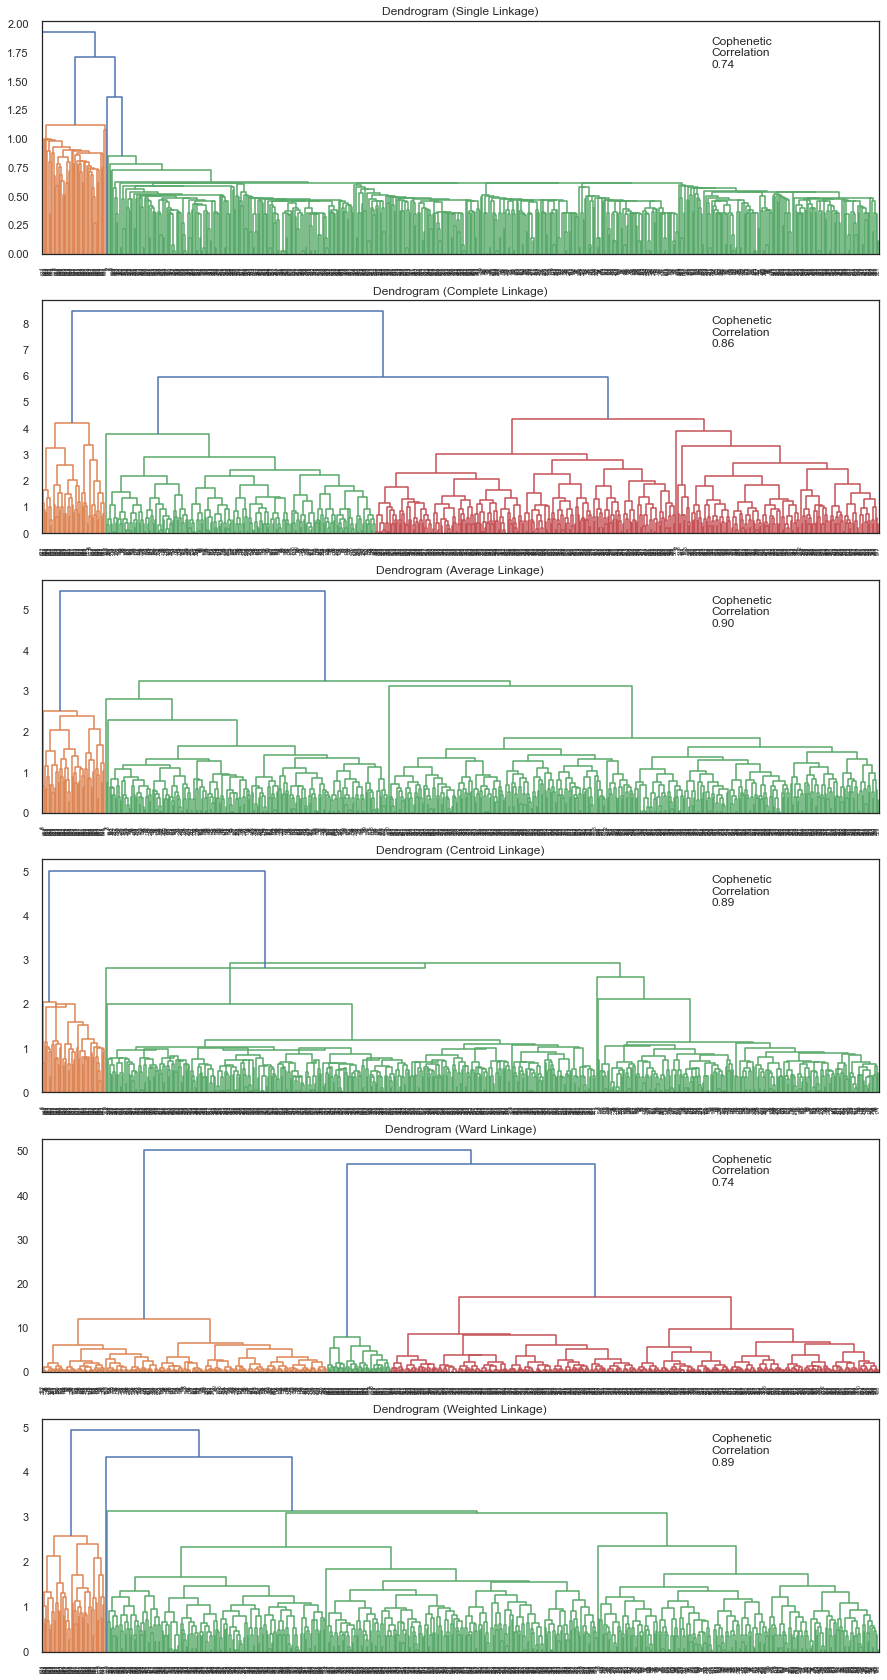

<IPython.core.display.Javascript object>

In [41]:
dendro_euclid(subset_scaled_df1)

- Dendrogram for **Ward linkage** shows distinct and separate clusters.

#### Let's see the dendrogram for Chebyshev and Manhattan distances with average linkage method (as they gave high cophenetic correlation values).

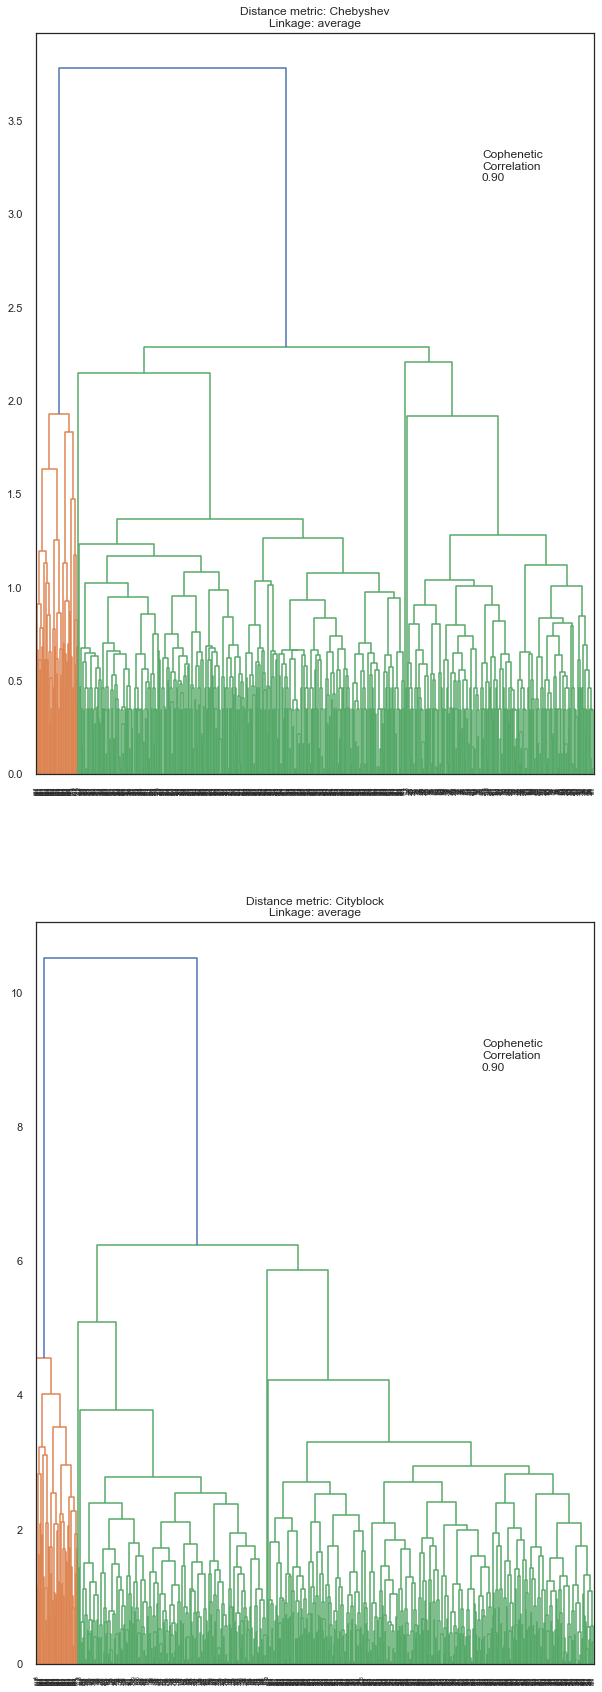

<IPython.core.display.Javascript object>

In [42]:
# list of distance metrics
distance_metrics = ["chebyshev", "cityblock"]

# to create a subplot image
fig, axs = plt.subplots(len(distance_metrics), 1, figsize=(10, 30))

i = 0
for dm in distance_metrics:
    Z = linkage(subset_scaled_df1, metric=dm, method="average")

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(
        "Distance metric: {}\nLinkage: {}".format(dm.capitalize(), "average")
    )

    c, coph_dist = cophenet(Z, pdist(subset_scaled_df1))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{c:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )
    i += 1

- Out of all the dendrograms we saw, it is clear that the dendrogram with Ward linkage gave us separate and distinct clusters.
- 4 would be the appropriate number of the clusters from the dendrogram with Ward linkage method.

In [43]:
HCmodel = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="ward")
HCmodel.fit(subset_scaled_df1)

AgglomerativeClustering(n_clusters=4)

<IPython.core.display.Javascript object>

In [44]:
# copying df and scaled df to another variable
df1_HC = df[num_col].copy()
subset_scaled_df1_HC = subset_scaled_df1.copy()

# adding hierarchical cluster labels to the original and scaled dataframes
subset_scaled_df1_HC["HC_Clusters"] = HCmodel.labels_
df1_HC["HC_Clusters"] = HCmodel.labels_

<IPython.core.display.Javascript object>

### 3.2.1) Cluster Profiling

In [45]:
cluster_profile_df1_HC = df1_HC.groupby("HC_Clusters").mean()

cluster_profile_df1_HC["count_in_each_segments_outliers"] = (
    df1_HC.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)

# let's display cluster profiles
cluster_profile_df1_HC.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments_outliers
HC_Clusters,,,,,,
0,12151.111111,2.422222,0.937778,3.546667,6.857778,225
1,38298.429319,5.670157,2.523560,0.947644,2.099476,191
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50
3,29474.226804,5.365979,4.448454,1.010309,1.891753,194


<IPython.core.display.Javascript object>

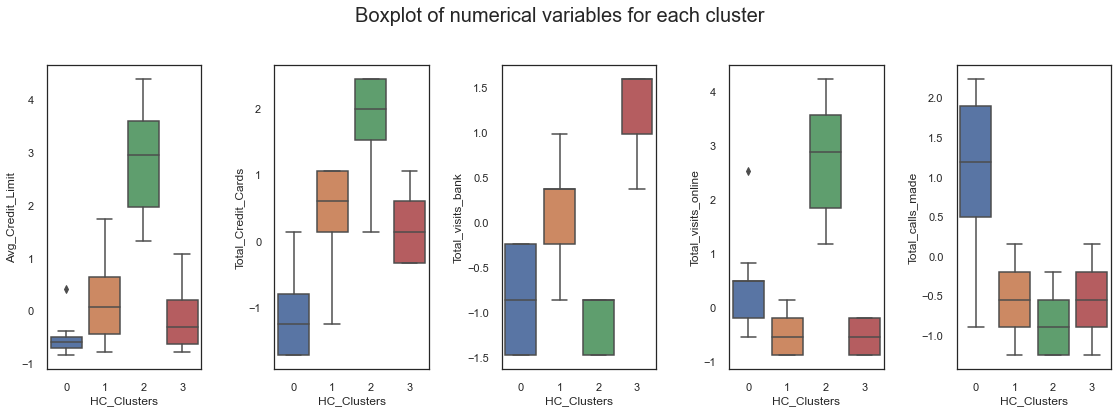

<IPython.core.display.Javascript object>

In [46]:
boxplot_cluster(subset_scaled_df1_HC, "HC_Clusters")

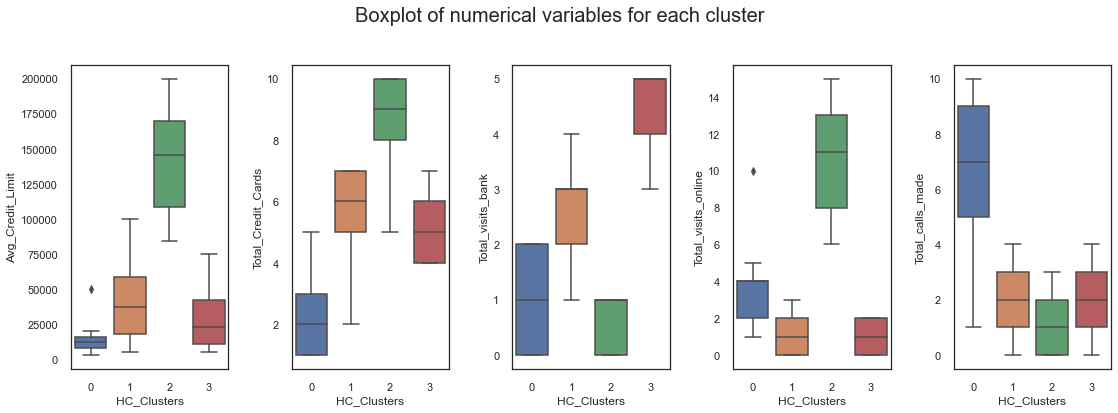

<IPython.core.display.Javascript object>

In [47]:
boxplot_cluster(df1_HC, "HC_Clusters")

### 3.2.2) Insights from Hierarchical Clustering for dataset with outliers:

- **Clusters 0**:
    - Very low average credit limit.
    - Majority of customers only hold 1 to 3 credit cards.
    - Most often contacted the bank for queries <ins>through a call centre</ins>.

- **Clusters 1**:
    - Low to medium average credit limit.
    - Majority of customers hold 5 to 7 credit cards.
    - Within this Cluster customers most often contacted the bank for queries <ins>by visiting the bank</ins>, but lesser than Clusters 3.
    - Least likely to contact the bank via online.
    
- **Clusters 2**:
    - High average credit limit.
    - Majority of customers hold 8 to 10 credit cards.
    - Most often contacted the bank for queries <ins>via online</ins>.

- **Clusters 3**:
    - Low average credit limit. Its range is only slighltly lower than Clusters 1.
    - Majority of customers hold 4 to 6 credit cards.
    - Most often contacted the bank for queries <ins>by visiting the bank</ins>, and relatively more than Cluster 1 does.
    - Least likely to contact the bank via online.

# 4) Clustering of dataset <ins>without outliers</ins>
## 4.1) K-means Clustering

In [48]:
sns.set_theme(style="whitegrid")

<IPython.core.display.Javascript object>

Number of Clusters: 1 	Average Distortion: 2.080654852025596
Number of Clusters: 2 	Average Distortion: 1.502444818334373
Number of Clusters: 3 	Average Distortion: 1.191529631817253
Number of Clusters: 4 	Average Distortion: 1.076088242191596
Number of Clusters: 5 	Average Distortion: 1.010517820222827
Number of Clusters: 6 	Average Distortion: 0.957990899649366
Number of Clusters: 7 	Average Distortion: 0.9206936659478321
Number of Clusters: 8 	Average Distortion: 0.8984441164105171


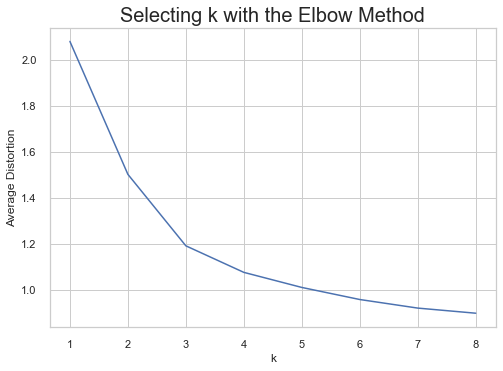

<IPython.core.display.Javascript object>

In [49]:
elbow_method(subset_scaled_df2)

- **Appropriate value for k seems to be 3 or 4.**|

For n_clusters = 2, silhouette score is 0.4209187627633144)
For n_clusters = 3, silhouette score is 0.5159967513890517)
For n_clusters = 4, silhouette score is 0.3847062320349616)
For n_clusters = 5, silhouette score is 0.35405440887245304)
For n_clusters = 6, silhouette score is 0.27158179351464506)
For n_clusters = 7, silhouette score is 0.26749866630405195)
For n_clusters = 8, silhouette score is 0.2561774033090225)
For n_clusters = 9, silhouette score is 0.248156548297177)


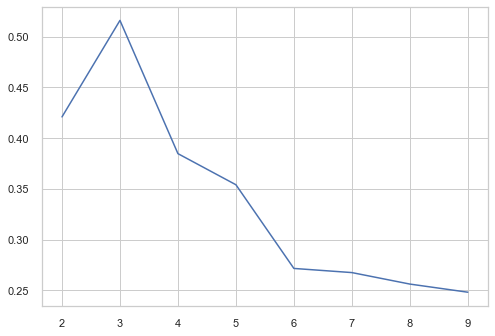

<IPython.core.display.Javascript object>

In [50]:
# Let's check the silhouette scores
sil_score(subset_scaled_df2)

- **Silhouette score for 3 is much higher than that for 4. So, we will choose 3 as value of k.**

In [51]:
# let's take 3 as number of clusters
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(subset_scaled_df2)

KMeans(n_clusters=3, random_state=0)

<IPython.core.display.Javascript object>

### 4.1.1) Cluster Profiling

In [52]:
# copying df and scaled df to another variable to retain original df for Hierarchical clustering
df2_Kmean = subset2.copy()
subset_scaled_df2_Kmean = subset_scaled_df2.copy()

df2_Kmean["K_means_segments_no_outliers"] = kmeans.labels_
subset_scaled_df2_Kmean["K_means_segments_no_outliers"] = kmeans.labels_

cluster_profile_df2_Kmean = df2_Kmean.groupby("K_means_segments_no_outliers").mean()

cluster_profile_df2_Kmean["count_in_each_segments_no_outliers"] = (
    df2_Kmean.groupby("K_means_segments_no_outliers")["Total_visits_bank"]
    .count()
    .values
)

# let's display cluster profiles
cluster_profile_df2_Kmean.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments_no_outliers
K_means_segments_no_outliers,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.544643,6.870536,224
2,98760.000000,8.740000,0.600000,7.820000,1.080000,50


<IPython.core.display.Javascript object>

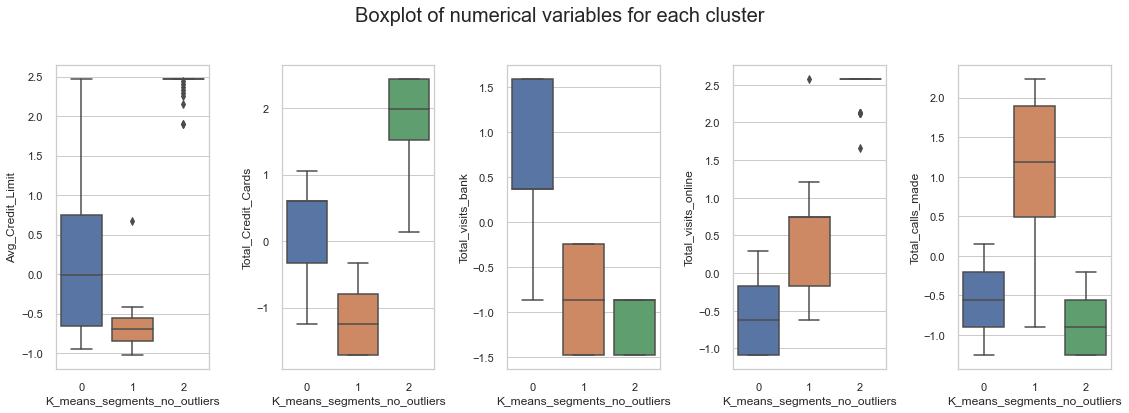

<IPython.core.display.Javascript object>

In [53]:
boxplot_cluster(subset_scaled_df2_Kmean, "K_means_segments_no_outliers")

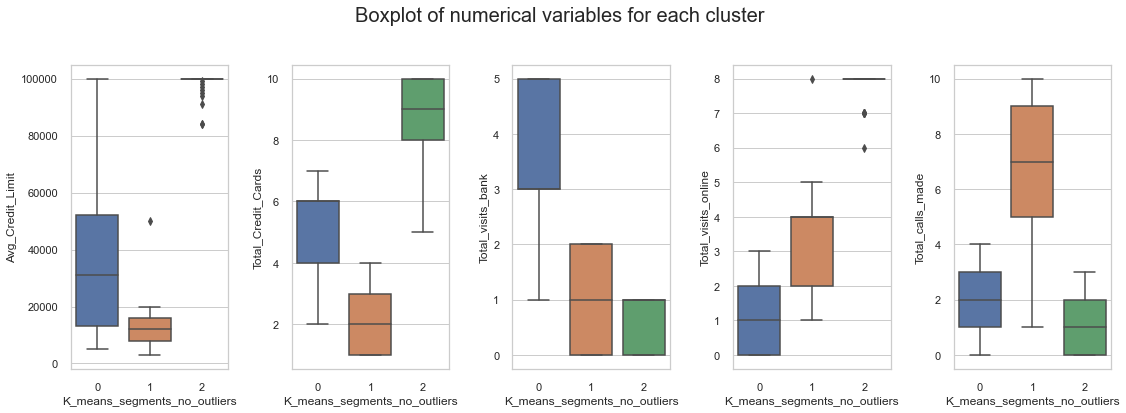

<IPython.core.display.Javascript object>

In [54]:
boxplot_cluster(df2_Kmean, "K_means_segments_no_outliers")

### 4.1.2) Insights from K-means Clustering for dataset without outliers:

- While the clustering outcome remains the same as the one with outliers, we have lost meaningful analytic insights of those customers with credit limits beyond 100000 and also lost the actual frequencies of customers who contacted the bank 8 to 15 times. 
- The observed outliers before clustering could actually form a distinct cluster itself.
- Hence, it isn't advisable to remove the outliers for this scenario.

## 4.2) Hierarchical Clustering

In [55]:
coph_corr(subset_scaled_df2)

Cophenetic correlation for Euclidean distance and single linkage is 0.6498586467714482.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8341674150360523.
Cophenetic correlation for Euclidean distance and average linkage is 0.8889258387502743.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8846634362170411.
Cophenetic correlation for Chebyshev distance and single linkage is 0.6727008644393819.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8525709353251941.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8852742818835211.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8782389194733742.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.6431650673507128.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.419258888123625.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.7953781097780815.
Cophenetic cor

<IPython.core.display.Javascript object>

**Again, let's explore different linkage methods with Euclidean distance only.**

In [56]:
coph_corr_sole_metric(subset_scaled_df2, "euclidean")

Cophenetic correlation for single linkage is 0.6498586467714482.
Cophenetic correlation for complete linkage is 0.8341674150360523.
Cophenetic correlation for average linkage is 0.8889258387502743.
Cophenetic correlation for centroid linkage is 0.8847554621645285.
Cophenetic correlation for ward linkage is 0.7701478928985553.
Cophenetic correlation for weighted linkage is 0.8846634362170411.

Highest cophenetic correlation is 0.8889258387502743, which is obtained with average linkage.


<IPython.core.display.Javascript object>

- We see that the cophenetic correlation from Euclidean distance is still maximum with average linkage.

#### Let's see the dendrograms for the different linkage methods.

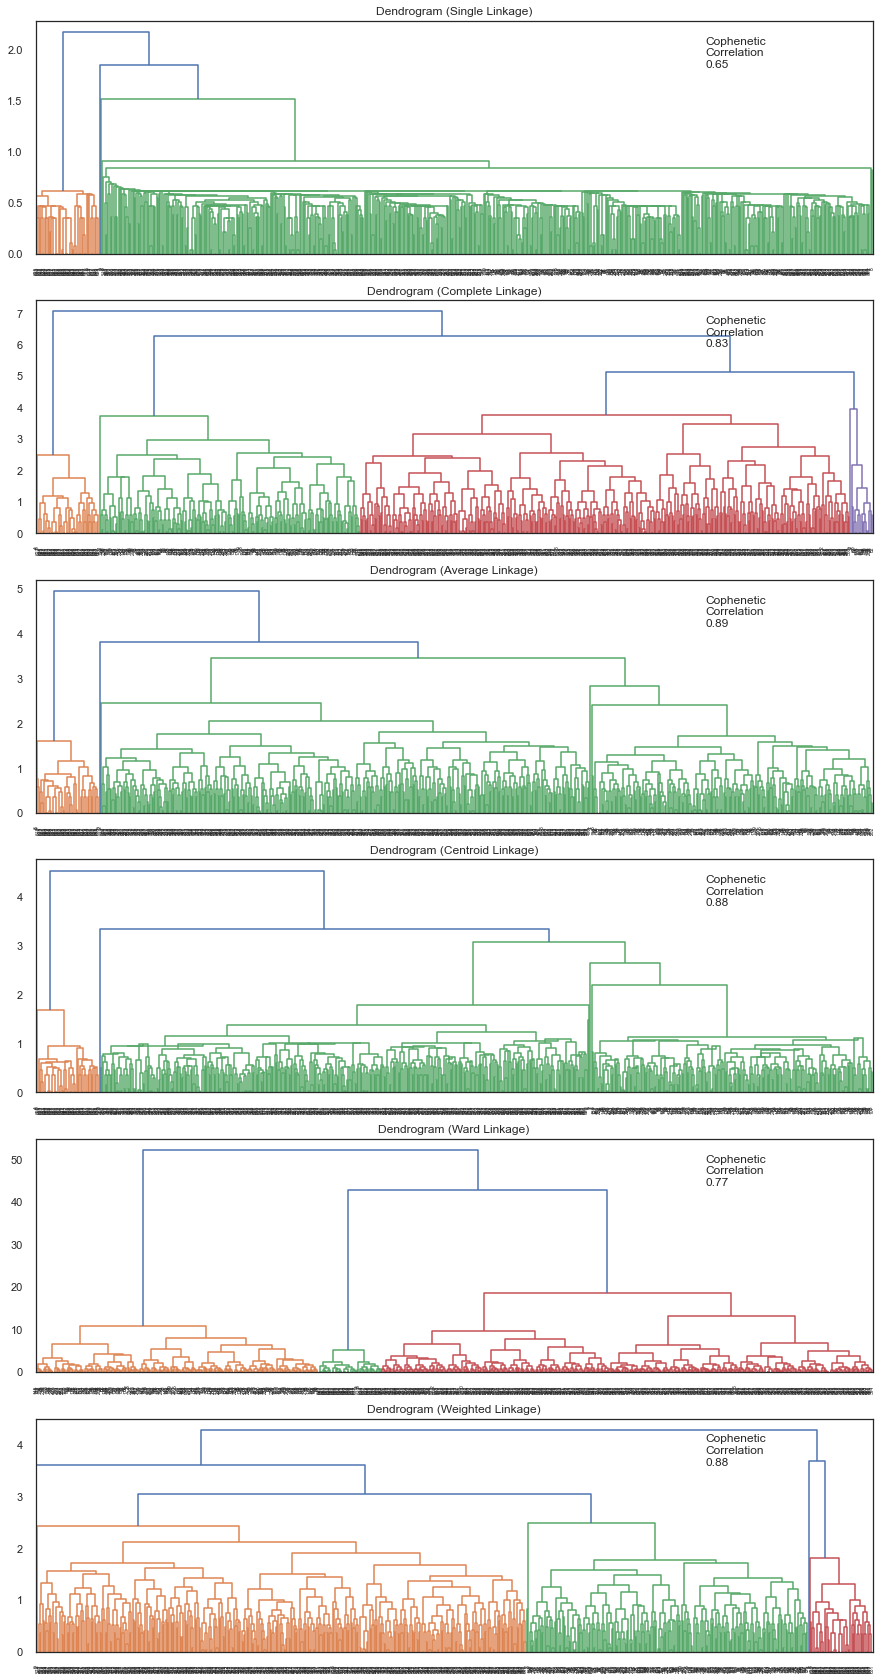

<IPython.core.display.Javascript object>

In [57]:
dendro_euclid(subset_scaled_df2)

- Dendrogram for **Ward linkage** shows distinct and separate clusters.
- Noticed that the dendrogram for Complete linkage has an additional distinct cluster compared with the dendrogram of Complete linkage with outliers.
- The dendrogram of Weighted Linkage is relatively more distinct and separate clusters than the one wih outliers.

#### Let's also see the dendrogram for Chebyshev and Manhattan distances with average linkage method (as they gave high cophenetic correlation values).

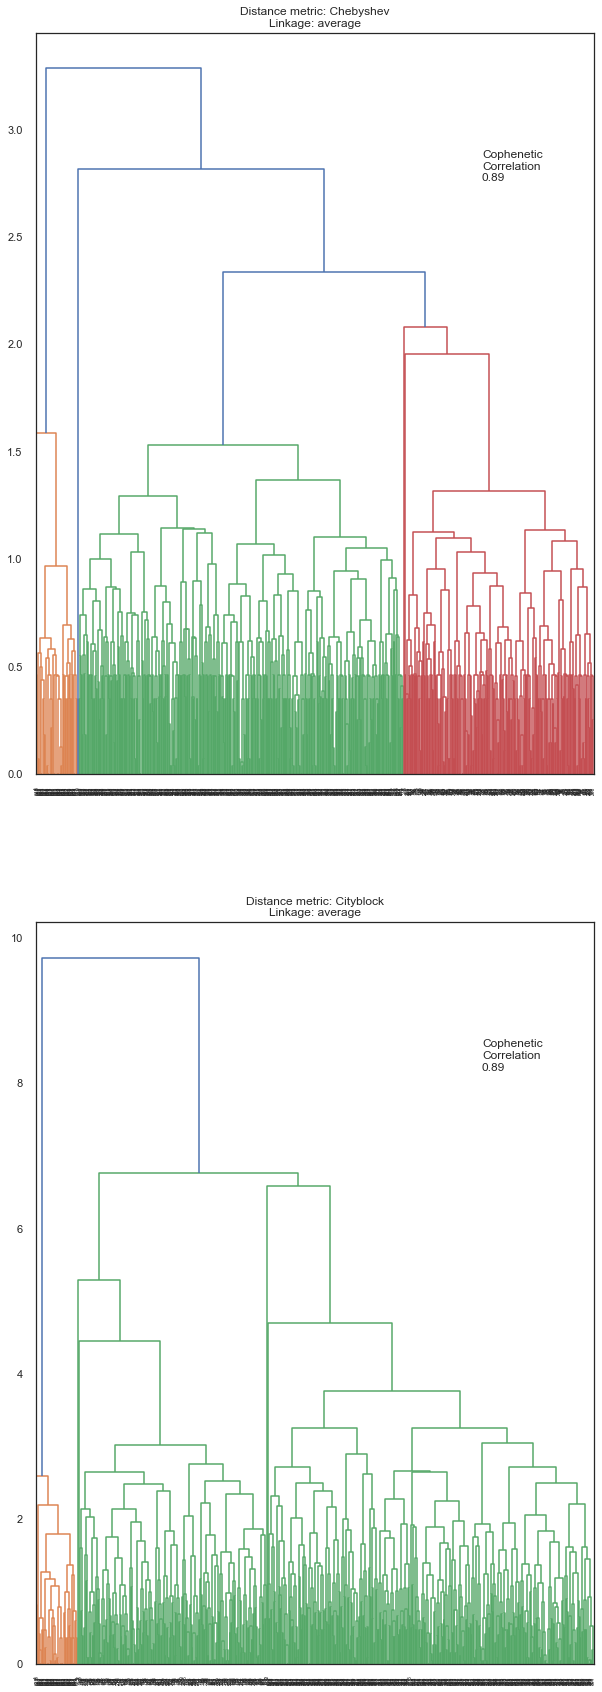

<IPython.core.display.Javascript object>

In [58]:
# list of distance metrics
distance_metrics = ["chebyshev", "cityblock"]

# to create a subplot image
fig, axs = plt.subplots(len(distance_metrics), 1, figsize=(10, 30))

i = 0
for dm in distance_metrics:
    Z = linkage(subset_scaled_df2, metric=dm, method="average")

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(
        "Distance metric: {}\nLinkage: {}".format(dm.capitalize(), "average")
    )

    c, coph_dist = cophenet(Z, pdist(subset_scaled_df2))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{c:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )
    i += 1

- Out of all the dendrograms we saw for the Hierarchical clustering without outliers, it is clear that the dendrogram with **Ward linkage** also gave us separate and distinct clusters.
- 4 would still be the appropriate number of the clusters from the dendrogram with Ward linkage method.

In [59]:
HCmodel2 = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="ward")
HCmodel2.fit(subset_scaled_df2)

AgglomerativeClustering(n_clusters=4)

<IPython.core.display.Javascript object>

In [60]:
# copying df and scaled df to another variable
df2_HC = subset2.copy()
subset_scaled_df2_HC = subset_scaled_df2.copy()

# adding hierarchical cluster labels to the original and scaled dataframes
subset_scaled_df2_HC["HC_Clusters"] = HCmodel2.labels_
df2_HC["HC_Clusters"] = HCmodel2.labels_

<IPython.core.display.Javascript object>

### 4.2.1) Cluster Profiling

In [61]:
cluster_profile_df2_HC = df2_HC.groupby("HC_Clusters").mean()

cluster_profile_df2_HC["count_in_each_segments_no_outliers"] = (
    df2_HC.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)

# let's display cluster profiles
cluster_profile_df2_HC.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments_no_outliers
HC_Clusters,,,,,,
0,16524.038462,5.475962,3.552885,1.038462,2.091346,208
1,12197.309417,2.403587,0.928251,3.551570,6.883408,223
2,98760.000000,8.740000,0.600000,7.820000,1.080000,50
3,53687.150838,5.553073,3.407821,0.921788,1.905028,179


<IPython.core.display.Javascript object>

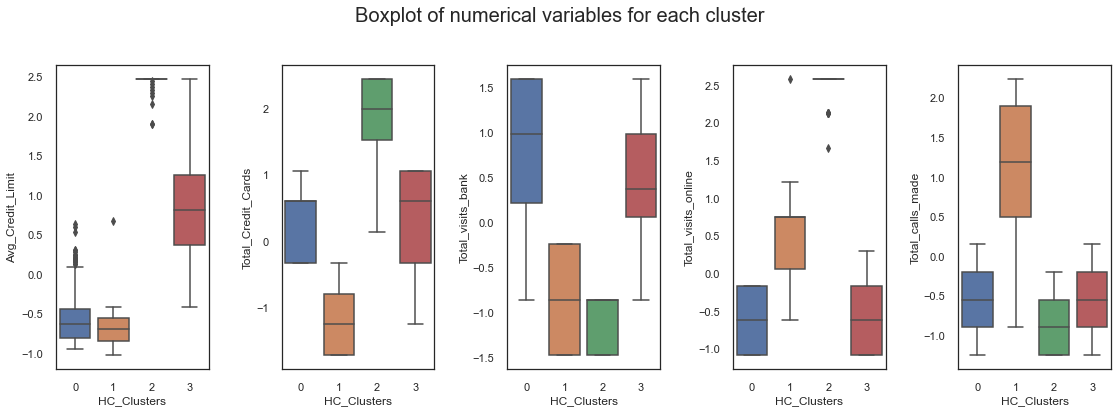

<IPython.core.display.Javascript object>

In [62]:
boxplot_cluster(subset_scaled_df2_HC, "HC_Clusters")

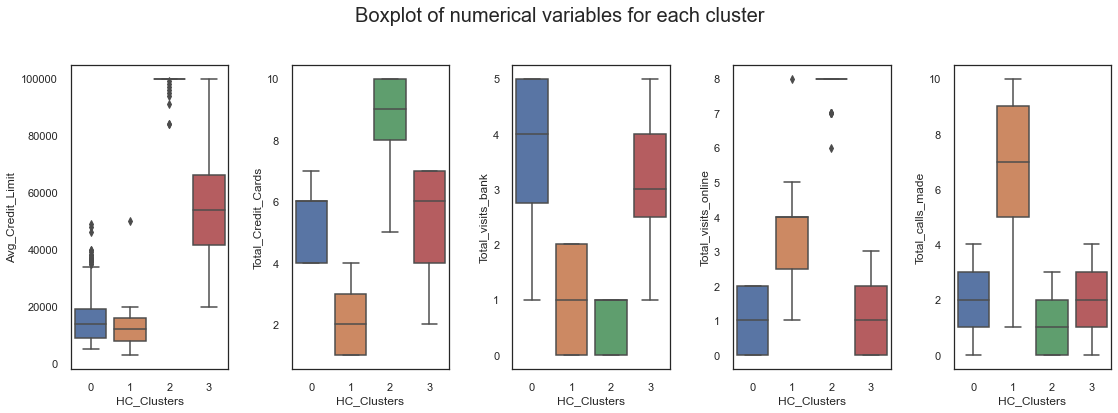

<IPython.core.display.Javascript object>

In [63]:
boxplot_cluster(df2_HC, "HC_Clusters")

### 4.2.2) Insights from Hierarchical Clustering for dataset without outliers:

- We can observe that the Cluster 0 here matches the Cluster 3 of Hierarchical Clustering for dataset with outliers (HC_outliers); while Clusters 1 is matches Cluster 0 of HC_outliers; Clusters 2 remains to match Cluster 2 of Clusters 1; and Cluster 3 matches CLuster 2 of HC_outliers.
- We however lost lots of insighful info after removing the outliers, hence it is better to derive insightes from HC_outliers.

# 5) Compare clusters obtained from K-means and Hierarchical clustering:

#### Let's display cluster profiles of K-means and Hierarchical clustering again.
### 5.1) K-means clustering:

In [64]:
# let's display cluster profiles of K-means clustering
cluster_profile_df1_Kmean.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments_outliers
K_means_segments_outliers,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

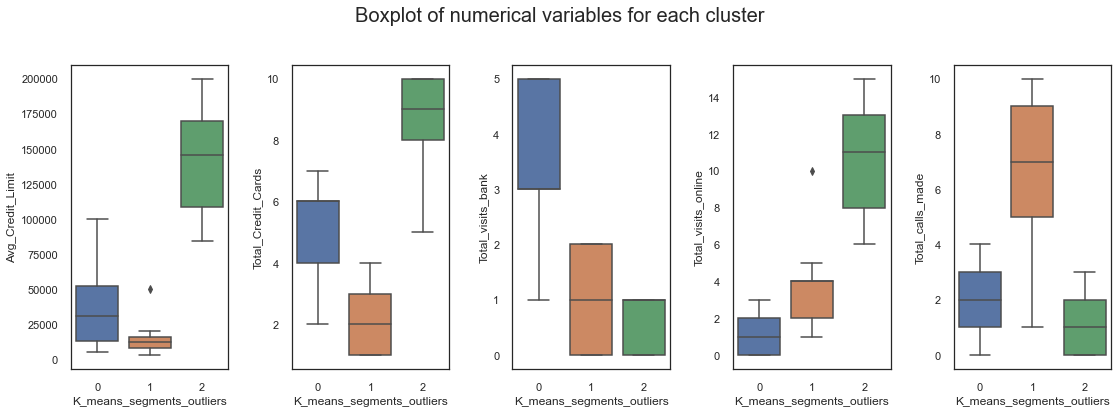

<IPython.core.display.Javascript object>

In [65]:
boxplot_cluster(df1_Kmean, "K_means_segments_outliers")

### 5.2) Hierarchical clustering:

In [66]:
cluster_profile_df1_HC.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments_outliers
HC_Clusters,,,,,,
0,12151.111111,2.422222,0.937778,3.546667,6.857778,225
1,38298.429319,5.670157,2.523560,0.947644,2.099476,191
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50
3,29474.226804,5.365979,4.448454,1.010309,1.891753,194


<IPython.core.display.Javascript object>

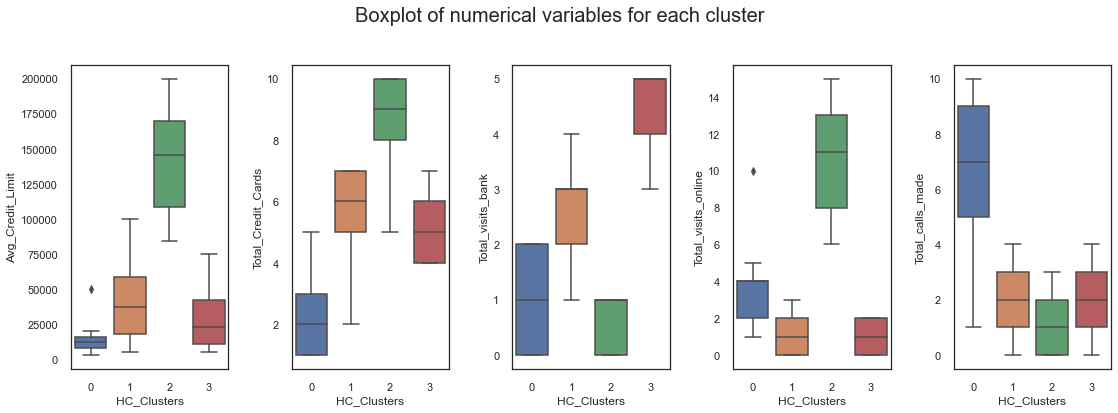

<IPython.core.display.Javascript object>

In [67]:
boxplot_cluster(df1_HC, "HC_Clusters")

**In order to better compare clusters from different clustering techniques, let's first set the format of categorization into cluster with highest average credit limit as Tier 1 customers, medium average credit limit as Tier 2, low average credit limit as Tier 3, and so on.**

- For the clusters from K-means Clustering:
        Cluster 0 is Tier 2; 
        Clusters 1 is Tier 3; and 
        Clusters 2 is Tier 1.
- For the clusters from Hierarchical Clustering:
        Cluster 0 is Tier 4; 
        Clusters 1 is Tier 2;  
        Clusters 2 is Tier 1; and
        Clusters 3 is Tier 3.
- We can observe that the boxplots of all features of Tier 1 from both clustering techniques are identical.
- We can aslo observe that the Tier 3 of K-means Clustering is almost identical to Tier 4 of Hierarchical Clustering. In fact there is only 1 customer that wasn't in Tier 3 of K-means Clustering being assigned to Tier 4 of Hierarchical Clustering. Let's check the details of this relocated customer below:

In [68]:
df1_HC[df1_HC["HC_Clusters"] == 0][df1_HC["Total_Credit_Cards"] == 5]

<ipython-input-68-680927ab5cee>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1_HC[df1_HC["HC_Clusters"] == 0][df1_HC["Total_Credit_Cards"] == 5]


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,HC_Clusters
288,7000,5,2,2,4,0


<IPython.core.display.Javascript object>

Every feature of this relocated customer has the value fell within the same boxplots of K-Means clustering except his number of credit cards. He holds 5 credit cards, which made him excluded from Tier 3 of K-Means clustering, which limited the number of credit cards to the range of 1 to 4.

- Therefore, Hierarchical Clustering actually split Tier 2 of K-Means clustering into two separate clusters, namely Cluster 1 (Tier 2) and Cluster 3 (Tier 3) in Hierarchical Clustering. From their boxplots we find that the main feature that separated the two clusters were Total_visits_bank, where by Tier 3 customers visited the bank more than Tier 2. Another feature that somewhat segragated them was Total_Credit_Cards, as we could see that Tier 2 customers tend to hold more credit cards than Tier 3 does.

# 6) Actionable Insights & Recommendations

- K-Means clustering seems to be a better choice for us to derive better reommendations, thus we will only discuss the Tier 1 to Tier 3 customers from K-Means clustering here.
- The bank should target Tier 2 customers of K-Means clustering (Cluster 0). One main reason is because they are more likely to apply for additional credit cards than other segmments of customers.
- The lowest Tier of customers are highly likely from low income segment (because they have very few credit cards across all banks). So they would be less likely to be qualified for more credit cards and even if approved for a new credit card, its credit limit would tend to be minimal. On the other hand, customers from the highest Tier would have lesser potential to extend addtional credit limit as they are being constrained by income.
-  As we notice that Tier 2 customers tend to contact the bank by visiting to the bank, the bank should focus to improve support services at their retail branches. 
- When servicing customers who visit to the bank, the bank staff should check the income of the customers, so that they can target those who have high income but only holding 3 to 6 credit cards.
- While having a very high average credit limit tends to imply having a high income, we should be alert that most of the customers from Tier 1 segment hold 8 to 10 credit cards. It means their income might not be high, but they applied for as many credit cards as possible from all the banks. In other words, the customer might have maximized his risk exposure limit already. 
- Nonetheless, when Tier 1 segment of customers contact the bank via online, we could check the number of credit cards they hold. Since it is through website portal, we can automate the process to find the minortiy who hold only 5 to 7 credit cards but earn high incomes. The bank could target them to sell credit cards, especially those whose most existing credit cards are from other banks.